<a href="https://colab.research.google.com/github/dutt2022/Coursera-Data-science-Projects/blob/main/tf_time_sereis_forecasr_finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import os



In [7]:
train= pd.read_csv('/content/drive/MyDrive/Coding_Machine_Learning/TIME-SERIES-SYNNAX/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Coding_Machine_Learning/TIME-SERIES-SYNNAX/test.csv')
targets_names = [col for col in train if col not in test]
print(targets_names)

['Q0_TOTAL_ASSETS', 'Q0_TOTAL_LIABILITIES', 'Q0_TOTAL_STOCKHOLDERS_EQUITY', 'Q0_GROSS_PROFIT', 'Q0_COST_OF_REVENUES', 'Q0_REVENUES', 'Q0_OPERATING_INCOME', 'Q0_OPERATING_EXPENSES', 'Q0_EBITDA']


In [8]:
quarters = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10']

In [9]:
train.shape

(1624, 212)

In [10]:
for target in targets_names:
    name = target.split('Q0_')[1]
    for quarter in quarters:
        quarter_target = f'{quarter}_{name}'
        if np.any(train[quarter_target].isnull()):
            print(quarter_target, train[quarter_target].isnull().sum())

Q1_TOTAL_ASSETS 1
Q2_TOTAL_ASSETS 1
Q3_TOTAL_ASSETS 8
Q4_TOTAL_ASSETS 4
Q5_TOTAL_ASSETS 5
Q6_TOTAL_ASSETS 13
Q7_TOTAL_ASSETS 148
Q8_TOTAL_ASSETS 31
Q9_TOTAL_ASSETS 98
Q10_TOTAL_ASSETS 178
Q3_TOTAL_LIABILITIES 5
Q4_TOTAL_LIABILITIES 1
Q5_TOTAL_LIABILITIES 2
Q6_TOTAL_LIABILITIES 13
Q7_TOTAL_LIABILITIES 139
Q8_TOTAL_LIABILITIES 25
Q9_TOTAL_LIABILITIES 95
Q10_TOTAL_LIABILITIES 175
Q2_TOTAL_STOCKHOLDERS_EQUITY 1
Q3_TOTAL_STOCKHOLDERS_EQUITY 5
Q4_TOTAL_STOCKHOLDERS_EQUITY 2
Q5_TOTAL_STOCKHOLDERS_EQUITY 3
Q6_TOTAL_STOCKHOLDERS_EQUITY 12
Q7_TOTAL_STOCKHOLDERS_EQUITY 140
Q8_TOTAL_STOCKHOLDERS_EQUITY 25
Q9_TOTAL_STOCKHOLDERS_EQUITY 96
Q10_TOTAL_STOCKHOLDERS_EQUITY 175
Q1_GROSS_PROFIT 7
Q2_GROSS_PROFIT 10
Q3_GROSS_PROFIT 35
Q4_GROSS_PROFIT 11
Q5_GROSS_PROFIT 19
Q6_GROSS_PROFIT 29
Q7_GROSS_PROFIT 179
Q8_GROSS_PROFIT 49
Q9_GROSS_PROFIT 118
Q10_GROSS_PROFIT 201
Q1_COST_OF_REVENUES 19
Q2_COST_OF_REVENUES 36
Q3_COST_OF_REVENUES 102
Q4_COST_OF_REVENUES 56
Q5_COST_OF_REVENUES 73
Q6_COST_OF_REVENUES 96
Q

### Imputing Missing Values

In [11]:
def impute_missing(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    for col in df.select_dtypes(exclude = 'O'):
        if np.any(df[col].isnull()):
            df[col].fillna(df[col].median(), inplace = True)
    assert df.select_dtypes(exclude = 'O').isnull().sum().sum() == 0
    return df

In [12]:
train['train'] = True
test['train'] = False
df = pd.concat([train, test], axis = 0, ignore_index = True)

In [13]:
df = impute_missing(df)

### Converting Categorical Columns

In [14]:
for col in df.select_dtypes(include = 'O'):
    print(f'{col} unique values num: {df[col].nunique()}')
    print('-'*50)

industry unique values num: 113
--------------------------------------------------
sector unique values num: 10
--------------------------------------------------
recommendationKey unique values num: 6
--------------------------------------------------
financialCurrency unique values num: 2
--------------------------------------------------


In [15]:
def binarize(df, col):
    uniques = list(df[col].dropna().unique())
    df[col] = [1 if val == uniques[0] else 0 for val in df[col]]
    return df

In [16]:
def one_hot_encode(df, col):
    dummies = pd.get_dummies(df[col], prefix = col).astype(int)
    df.drop(col, axis = 1, inplace = True)
    df = pd.concat([df, dummies], axis = 1)
    return df

In [17]:
def factorize(df, col):
    mapping = {name: ix for ix, name in enumerate(df[col].unique())}
    df[col] = df[col].map(mapping)
    return df

In [18]:
df = binarize(df, 'financialCurrency')
print(df['financialCurrency'].head())

0    1
1    1
2    0
3    1
4    1
Name: financialCurrency, dtype: int64


In [19]:
print(df.shape)
df = one_hot_encode(df, 'sector')
df = one_hot_encode(df, 'recommendationKey')
print(df.shape)

(2030, 213)
(2030, 227)


In [20]:
df = factorize(df, 'industry')
print(df.dtypes.value_counts())

float64    207
int64       19
bool         1
dtype: int64


### Splitting into Train Test

In [21]:
train = df[df['train'] == True]
test = df[df['train'] == False]
train.drop('train', axis = 1, inplace=True)
test.drop('train', axis = 1, inplace=True)
test.reset_index(drop = True, inplace = True)

In [22]:
targets = train[targets_names].copy()

In [23]:
def transform_data_to_target_time_series(df):
    time_series_dict = {}
    for ix in tqdm(df.index):
        if str(ix) not in time_series_dict:
            time_series_dict[str(ix)] = {}
        for target in targets_names:
            if target not in time_series_dict[str(ix)]:
                time_series_dict[str(ix)][target] = []
            time_series_for_ix_target = []
            for quarter in quarters:
                retrospect_target = f'{quarter}_{target.split("Q0_")[1]}'
                time_series_for_ix_target.append(df.loc[ix, retrospect_target])
            time_series_dict[str(ix)][target] = time_series_for_ix_target
    for ix, company_time_series in time_series_dict.items():
        for target, time_series in company_time_series.items():
            time_series_dict[ix][target] = time_series[::-1]
    return time_series_dict

In [24]:
time_series_dict = transform_data_to_target_time_series(test)

100%|██████████| 406/406 [00:00<00:00, 1265.34it/s]


In [25]:
company_Id = list(time_series_dict.keys())[0]
time_series_dict[company_Id]

{'Q0_TOTAL_ASSETS': [660818000.0,
  613224500.0,
  3807886.0,
  -601997799.0,
  4666476.0,
  4665296.0,
  3127364.0,
  -9291429.0,
  3474103.0,
  3246148.0],
 'Q0_TOTAL_LIABILITIES': [290163000.0,
  259555000.0,
  1531665.0,
  -174354387.5,
  4048731.0,
  4719074.0,
  3652504.0,
  -8201194.0,
  4336123.0,
  4410785.0],
 'Q0_TOTAL_STOCKHOLDERS_EQUITY': [242431000.0,
  233196732.4440296,
  2366105.44748958,
  -219738422.10035214,
  2899607.3632927523,
  2898874.146902336,
  1943249.613219199,
  -5773413.587450534,
  2158702.764063812,
  2017058.406201605],
 'Q0_GROSS_PROFIT': [34239000.0,
  33205000.0,
  787.0,
  43967000.0,
  191.0,
  12024.0,
  9404.0,
  -196714.0,
  1134.0,
  -57.0],
 'Q0_COST_OF_REVENUES': [29579500.0,
  27879000.0,
  7058.0,
  39439073.5,
  9956.0,
  20840.0,
  23969.0,
  245992.0,
  967.0,
  132.0],
 'Q0_REVENUES': [103181000.0,
  100216000.0,
  7845.0,
  124887000.0,
  10147.0,
  32864.0,
  33373.0,
  49278.0,
  2101.0,
  75.0],
 'Q0_OPERATING_INCOME': [-38304.0,


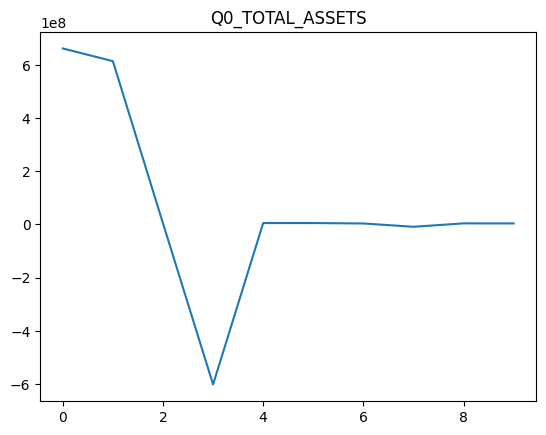

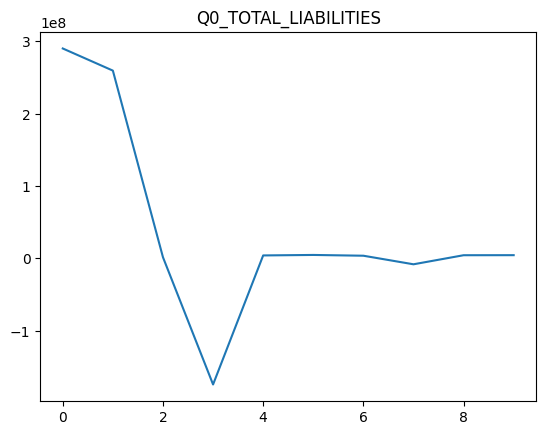

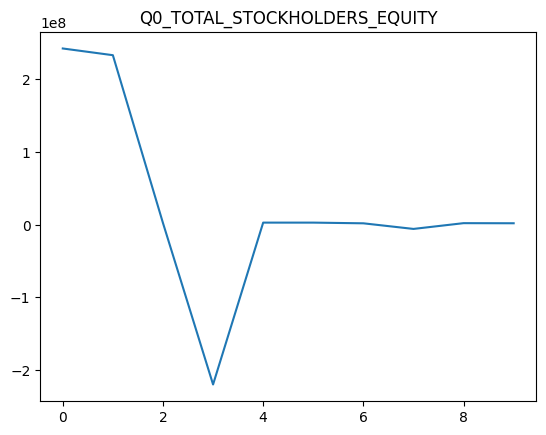

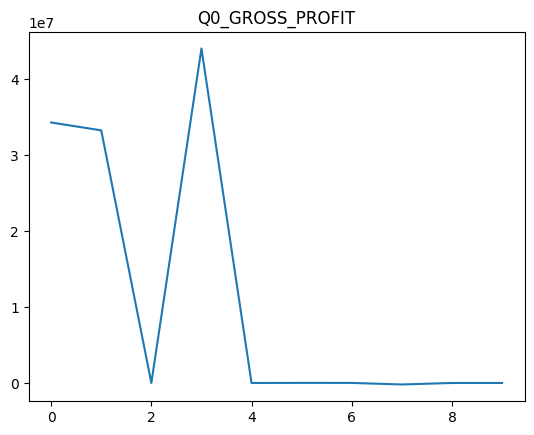

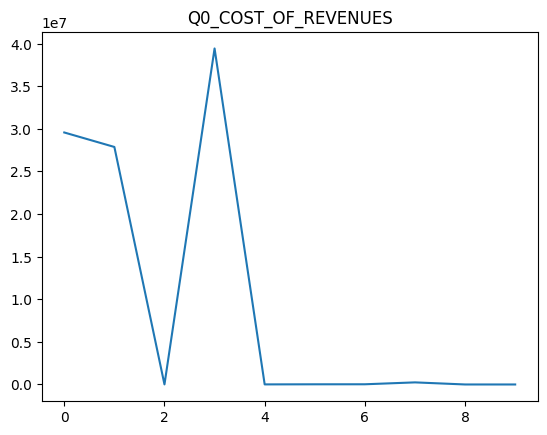

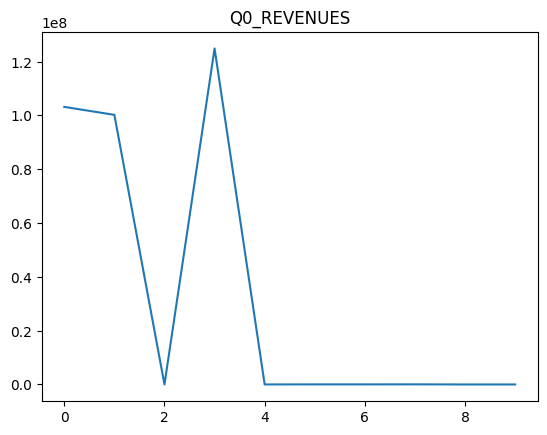

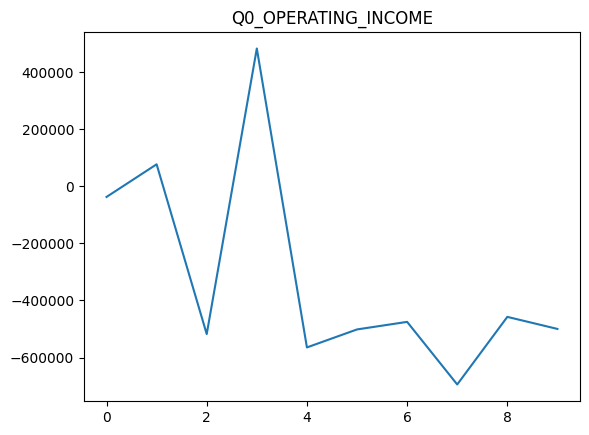

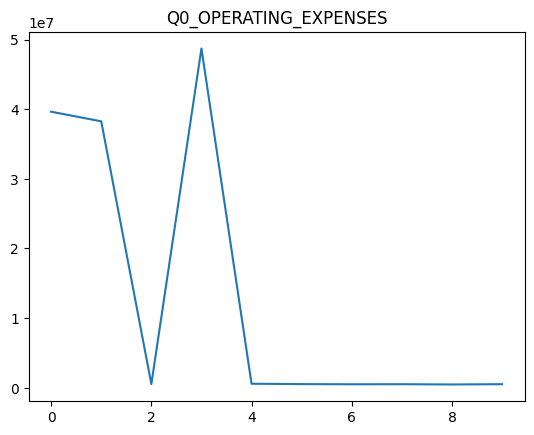

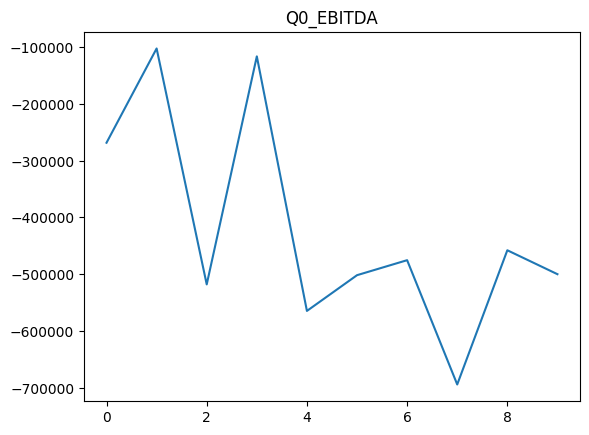

In [26]:
for feature, time_series in time_series_dict['0'].items():
    pd.Series(time_series).plot(title = feature)
    plt.show()

In [27]:
def fit_arima_make_forecast(time_series):
    # fit model
    model = ARIMA(time_series, order=(0,1,0))
    try:
        model_fit = model.fit()
    except:
        model.initialize_approximate_diffuse() # to handle potential LinAlgError
        model_fit = model.fit()
    pred = model_fit.forecast()
    return pred

In [28]:
# make predictions for each ix
forecast_dict = {}
for ix in tqdm(time_series_dict):
    if str(ix) not in forecast_dict:
        forecast_dict[str(ix)] = {}
    for target, time_series in time_series_dict[ix].items():
        if target not in forecast_dict[str(ix)]:
            forecast_dict[str(ix)][target] = []
            time_series = [np.log1p(val) for val in time_series]
        forecast = fit_arima_make_forecast(time_series)
        forecast = np.expm1(forecast)
        forecast_dict[str(ix)][target] = forecast

100%|██████████| 406/406 [00:44<00:00,  9.21it/s]


In [29]:
sub = pd.read_csv('/content/drive/MyDrive/Coding_Machine_Learning/TIME-SERIES-SYNNAX/sample_submission.csv')
for ix in forecast_dict:
    for target in forecast_dict[ix]:
        sub.loc[int(ix), target] = forecast_dict[ix][target]

In [30]:
sub.isnull().sum()

Id                              0
Q0_REVENUES                     0
Q0_COST_OF_REVENUES             0
Q0_GROSS_PROFIT                 0
Q0_OPERATING_EXPENSES           0
Q0_EBITDA                       0
Q0_OPERATING_INCOME             0
Q0_TOTAL_ASSETS                 0
Q0_TOTAL_LIABILITIES            0
Q0_TOTAL_STOCKHOLDERS_EQUITY    0
dtype: int64

In [31]:
sub.fillna(sub.mean(), inplace = True)

In [32]:
sub.to_csv('submission.csv', index = False)

In [33]:
sub.head(15)

,Id,Q0_REVENUES,Q0_COST_OF_REVENUES,Q0_GROSS_PROFIT,Q0_OPERATING_EXPENSES,Q0_EBITDA,Q0_OPERATING_INCOME,Q0_TOTAL_ASSETS,Q0_TOTAL_LIABILITIES,Q0_TOTAL_STOCKHOLDERS_EQUITY
0,480,7.500000e+01,1.320000e+02,1.134000e+03,499945.0,0.0,481055.0,3.246148e+06,4.410785e+06,2.017058e+06
1,573,5.990460e+08,3.790250e+08,2.200210e+08,105570000.0,114451000.0,80084000.0,3.700886e+09,1.401267e+09,3.181690e+08
2,1967,9.021600e+07,2.493450e+07,0.000000e+00,105915.0,0.0,481055.0,1.318184e+07,5.586564e+06,6.941350e+06
3,57,4.269620e+08,2.567660e+08,1.701960e+08,82896000.0,87300000.0,87300000.0,5.574579e+09,2.812815e+09,3.110644e+09
4,131,1.046000e+09,8.369000e+08,2.091000e+08,85400000.0,123700000.0,120300000.0,4.434700e+09,3.125500e+09,1.194000e+09
5,853,0.000000e+00,0.000000e+00,0.000000e+00,28955000.0,0.0,481055.0,2.690260e+08,2.130400e+07,2.477220e+08
6,78,1.952100e+09,1.507400e+09,4.447000e+08,145600000.0,299100000.0,284400000.0,8.106500e+09,4.760741e+09,3.848600e+09
7,1630,1.922100e+07,2.236000e+06,1.698500e+07,30046000.0,0.0,0.0,3.099430e+08,1.276580e+08,1.822850e+08
8,963,4.860561e+06,4.330655e+06,5.299060e+05,4049216.0,0.0,0.0,1.403528e+07,5.409407e+06,8.625875e+06
9,1377,3.251000e+09,2.609000e+09,6.420000e+08,213000000.0,429000000.0,396000000.0,2.098100e+10,9.904000e+09,1.054400e+10
